## Variable meanings

- **Target** = center-cell GOES fire confidence at time `t+1`, converted to binary class
- **Positive class (1)** = `confidence_t+1 >= 0.10`
- **Negative class (0)** = `confidence_t+1 < 0.10`
- **Neighbor features** = all available cell data at time `t` for each of the surrounding 8 cells
- **Variables per neighbor**:
  - `GOES_conf` (GOES fire confidence)
  - `TMP` (RTMA temperature)
  - `WIND` (RTMA wind speed)
  - `WDIR` (RTMA wind direction)
  - `SPFH` (RTMA specific humidity)
  - `ACPC01` (RTMA hourly precipitation)
- **Neighbor order** = `NW, N, NE, W, E, SW, S, SE`
- **Model** = logistic regression (streaming SGD optimization)


## Summary

- Data: GOES hourly confidence (~2 km) + RTMA hourly meteorology
- Task: predict whether next-hour center-cell confidence crosses 0.10 using 8-neighbor features at current hour
- Split: deterministic sample-level train/test split (`70%` train, `30%` test)
- Training: logistic regression on train split only (features standardized from train stats)
- Evaluation: held-out test **accuracy only**


In [13]:
from pathlib import Path

# Optional overrides if not running from repo root.
# GOES_JSON_PATH = "/abs/path/to/goes.json"
# RTMA_MANIFEST_PATH = "/abs/path/to/rtma_manifest.json"
GOES_JSON_PATH = None
RTMA_MANIFEST_PATH = None

# Optional: save computed report JSON
# REPORT_OUTPUT_PATH = "data/analysis/august_locational/neighbor_cell_confidence_logistic_report.json"
REPORT_OUTPUT_PATH = None

# Optional: limit hours for debugging (None = all aligned hours)
MAX_HOURS = None

# Split and classification settings.
TRAIN_FRACTION = 0.70
SPLIT_SEED = 42
POSITIVE_THRESHOLD = 0.10
CLASSIFICATION_PROB_THRESHOLD = 0.50

print("cwd:", Path.cwd())
print("train fraction:", TRAIN_FRACTION)
print("test fraction:", 1.0 - TRAIN_FRACTION)
print("split seed:", SPLIT_SEED)
print("positive confidence threshold:", POSITIVE_THRESHOLD)
print("classification probability threshold:", CLASSIFICATION_PROB_THRESHOLD)


cwd: /Users/seanmay/Desktop/Current Projects/wildfire-prediction/docs
train fraction: 0.7
test fraction: 0.30000000000000004
split seed: 42
positive confidence threshold: 0.1
classification probability threshold: 0.5


In [14]:
import json
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import Resampling, reproject
from sklearn.linear_model import SGDClassifier


def parse_iso(value: str) -> datetime:
    if value.endswith("Z"):
        value = value[:-1] + "+00:00"
    return datetime.fromisoformat(value)


def normalize_time_str(value: str) -> str:
    dt = parse_iso(value)
    return dt.strftime("%Y-%m-%dT%H:00:00Z")


def affine_from_list(vals: list) -> rasterio.Affine:
    return rasterio.Affine(vals[0], vals[1], vals[2], vals[3], vals[4], vals[5])


def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "data").exists() and (p / "scripts").exists() and (p / "docs").exists():
            return p
    raise FileNotFoundError("Could not find repo root containing data/, scripts/, docs/.")


def find_default_path(override, repo_root: Path, candidates):
    if override:
        p = Path(override).expanduser()
        if p.exists():
            return p
        raise FileNotFoundError(f"Provided path not found: {p}")

    for c in candidates:
        p = (repo_root / c).resolve()
        if p.exists():
            return p
    raise FileNotFoundError("Could not resolve default path. Set override variable in the config cell.")


def load_goes_times(goes_meta: dict, goes_conf: np.ndarray):
    goes_time_steps = goes_meta.get("time_steps", [])
    goes_start = goes_meta.get("start_time")

    if goes_time_steps and isinstance(goes_time_steps[0], (int, float)):
        if not goes_start:
            raise ValueError("GOES time_steps are numeric and metadata.start_time is missing.")
        start_dt = parse_iso(goes_start)
        goes_time_steps = [
            (start_dt + timedelta(hours=int(i - 1))).strftime("%Y-%m-%dT%H:00:00Z")
            for i in goes_time_steps
        ]
    elif not goes_time_steps and goes_start:
        start_dt = parse_iso(goes_start)
        goes_time_steps = [
            (start_dt + timedelta(hours=i)).strftime("%Y-%m-%dT%H:00:00Z")
            for i in range(goes_conf.shape[0])
        ]
    else:
        goes_time_steps = [normalize_time_str(t) for t in goes_time_steps]

    if not goes_time_steps:
        raise ValueError("GOES metadata has no usable time_steps.")

    return goes_time_steps


REPO_ROOT = find_repo_root(Path.cwd())

GOES_PATH = find_default_path(
    GOES_JSON_PATH,
    REPO_ROOT,
    candidates=[
        "data/ee_exports/August_Complex_2020_GOESEast_MaxConf.json",
    ],
)

RTMA_MANIFEST = find_default_path(
    RTMA_MANIFEST_PATH,
    REPO_ROOT,
    candidates=[
        "data/rtma/august_24h/rtma_manifest.json",
    ],
)

print("repo root:", REPO_ROOT)
print("GOES JSON:", GOES_PATH)
print("RTMA manifest:", RTMA_MANIFEST)


repo root: /Users/seanmay/Desktop/Current Projects/wildfire-prediction
GOES JSON: /Users/seanmay/Desktop/Current Projects/wildfire-prediction/data/ee_exports/August_Complex_2020_GOESEast_MaxConf.json
RTMA manifest: /Users/seanmay/Desktop/Current Projects/wildfire-prediction/data/rtma/august_24h/rtma_manifest.json


In [15]:
with GOES_PATH.open("r", encoding="utf-8") as f:
    goes_json = json.load(f)
with RTMA_MANIFEST.open("r", encoding="utf-8") as f:
    rtma_manifest = json.load(f)

goes_conf = np.array(goes_json["data"], dtype=np.float32)
goes_meta = goes_json["metadata"]
goes_transform = affine_from_list(goes_meta["geo_transform"])
goes_crs = goes_meta.get("crs")
goes_shape = tuple(goes_meta["grid_shape"])
goes_time_steps = load_goes_times(goes_meta, goes_conf)

go_time_index = {t: i for i, t in enumerate(goes_time_steps)}
rtma_time_steps = [normalize_time_str(t) for t in rtma_manifest["time_steps"]]
aligned_times = [t for t in rtma_time_steps if t in go_time_index and (go_time_index[t] + 1) < goes_conf.shape[0]]

print("GOES shape [T,H,W]:", goes_conf.shape)
print("GOES grid shape metadata:", goes_shape)
print("RTMA variables:", rtma_manifest["variables"])
print("Aligned hours with t+1 available:", len(aligned_times))

if len(aligned_times) == 0:
    raise RuntimeError("No aligned hours with t+1 available between GOES and RTMA.")


GOES shape [T,H,W]: (1512, 105, 183)
GOES grid shape metadata: (105, 183)
RTMA variables: ['TMP', 'WIND', 'WDIR', 'SPFH', 'ACPC01']
Aligned hours with t+1 available: 1511


In [16]:
NEIGHBORS = [
    ("nw", -1, -1),
    ("n", -1, 0),
    ("ne", -1, 1),
    ("w", 0, -1),
    ("e", 0, 1),
    ("sw", 1, -1),
    ("s", 1, 0),
    ("se", 1, 1),
]
VAR_ORDER = ["GOES_conf", "TMP", "WIND", "WDIR", "SPFH", "ACPC01"]
RTMA_VARS_REQUIRED = ["TMP", "WIND", "WDIR", "SPFH", "ACPC01"]


def feature_names():
    names = []
    for n_name, _, _ in NEIGHBORS:
        for v in VAR_ORDER:
            names.append(f"{v}_{n_name}")
    return names


FEATURE_NAMES = feature_names()
N_FEATURES = len(FEATURE_NAMES)


def to_binary_target(y_continuous: np.ndarray, threshold: float) -> np.ndarray:
    return (y_continuous >= threshold).astype(np.int32)


def train_mask_for_hour(n_rows: int, hour_index: int, train_fraction: float, split_seed: int) -> np.ndarray:
    if not (0.0 < train_fraction < 1.0):
        raise ValueError("TRAIN_FRACTION must be between 0 and 1.")
    rng = np.random.default_rng(int(split_seed) + int(hour_index))
    return rng.random(n_rows) < train_fraction


def resolve_manifest_file_path(path_str: str, repo_root: Path, manifest_dir: Path) -> Path:
    p = Path(path_str).expanduser()
    if p.exists():
        return p

    parts = p.parts
    if "data" in parts:
        idx = parts.index("data")
        candidate = repo_root.joinpath(*parts[idx:])
        if candidate.exists():
            return candidate

    candidate = (manifest_dir / path_str).resolve()
    if candidate.exists():
        return candidate

    raise FileNotFoundError(f"Could not resolve RTMA part path: {path_str}")


def resample_stack(src_stack, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    bands = src_stack.shape[0]
    dst = np.empty((bands, dst_shape[0], dst_shape[1]), dtype=np.float32)
    for b in range(bands):
        reproject(
            source=src_stack[b],
            destination=dst[b],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )
    return dst


def build_hour_samples(conf_t, conf_t1, rtma_hour):
    # Use only interior cells so all 8 neighbors exist.
    h, w = conf_t.shape
    if h < 3 or w < 3:
        return np.empty((0, N_FEATURES), dtype=np.float64), np.empty((0,), dtype=np.float64)

    y = conf_t1[1:-1, 1:-1].astype(np.float64)
    feat_blocks = []

    for _, dy, dx in NEIGHBORS:
        ys = slice(1 + dy, h - 1 + dy)
        xs = slice(1 + dx, w - 1 + dx)

        go_n = conf_t[ys, xs].astype(np.float64)
        tmp_n = rtma_hour["TMP"][ys, xs].astype(np.float64)
        wind_n = rtma_hour["WIND"][ys, xs].astype(np.float64)
        wdir_n = rtma_hour["WDIR"][ys, xs].astype(np.float64)
        spfh_n = rtma_hour["SPFH"][ys, xs].astype(np.float64)
        precip_n = rtma_hour["ACPC01"][ys, xs].astype(np.float64)

        feat_blocks.extend([go_n, tmp_n, wind_n, wdir_n, spfh_n, precip_n])

    X = np.stack(feat_blocks, axis=-1).reshape(-1, N_FEATURES)
    y = y.reshape(-1)

    valid = np.isfinite(y)
    valid &= np.isfinite(X).all(axis=1)

    if not valid.any():
        return np.empty((0, N_FEATURES), dtype=np.float64), np.empty((0,), dtype=np.float64)

    return X[valid], y[valid]


def iter_aligned_hours(goes_conf, goes_time_index, rtma_manifest, max_hours=None):
    rtma_vars = rtma_manifest["variables"]
    for req in RTMA_VARS_REQUIRED:
        if req not in rtma_vars:
            raise KeyError(f"RTMA manifest missing required variable: {req}")

    manifest_dir = RTMA_MANIFEST.parent
    rtma_files = rtma_manifest["files"]
    resolved_files = {
        var: [resolve_manifest_file_path(p, REPO_ROOT, manifest_dir) for p in rtma_files[var]]
        for var in rtma_vars
    }

    n_parts = len(resolved_files[rtma_vars[0]])
    for v in rtma_vars:
        if len(resolved_files[v]) != n_parts:
            raise ValueError("RTMA variable file lists do not have equal part counts.")

    parts = list(zip(*[resolved_files[v] for v in rtma_vars]))
    rtma_time_steps = [normalize_time_str(t) for t in rtma_manifest["time_steps"]]

    yielded = 0
    rtma_time_ptr = 0

    for part_paths in parts:
        rtma_arrays = {}
        rtma_transform = None
        rtma_crs = None
        band_count = None

        for var, path in zip(rtma_vars, part_paths):
            with rasterio.open(path) as ds:
                if rtma_transform is None:
                    rtma_transform = ds.transform
                    rtma_crs = ds.crs
                    band_count = ds.count
                rtma_arrays[var] = ds.read().astype("float32")

        if band_count is None:
            continue

        resampled = {}
        for var in rtma_vars:
            resampled[var] = resample_stack(
                rtma_arrays[var],
                rtma_transform,
                rtma_crs,
                goes_shape,
                goes_transform,
                goes_crs,
            )

        for local_idx in range(band_count):
            global_idx = rtma_time_ptr + local_idx
            if global_idx >= len(rtma_time_steps):
                break

            time_str = rtma_time_steps[global_idx]
            if time_str not in goes_time_index:
                continue

            t = goes_time_index[time_str]
            if t + 1 >= goes_conf.shape[0]:
                continue

            rtma_hour = {var: resampled[var][local_idx] for var in RTMA_VARS_REQUIRED}
            yield t, time_str, rtma_hour

            yielded += 1
            if max_hours is not None and yielded >= max_hours:
                return

        rtma_time_ptr += band_count


print("feature count:", N_FEATURES)
print("first 10 feature names:", FEATURE_NAMES[:10])


feature count: 48
first 10 feature names: ['GOES_conf_nw', 'TMP_nw', 'WIND_nw', 'WDIR_nw', 'SPFH_nw', 'ACPC01_nw', 'GOES_conf_n', 'TMP_n', 'WIND_n', 'WDIR_n']


In [17]:
# Pass 1: split samples into train/test and compute train feature moments.

sum_x_train = np.zeros(N_FEATURES, dtype=np.float64)
sum_x2_train = np.zeros(N_FEATURES, dtype=np.float64)

n_total_samples = 0
n_train_samples = 0
n_test_samples = 0
n_hours_used = 0

train_pos = 0
train_neg = 0
test_pos = 0
test_neg = 0

for t, time_str, rtma_hour in iter_aligned_hours(goes_conf, go_time_index, rtma_manifest, max_hours=MAX_HOURS):
    X_hour, y_hour_cont = build_hour_samples(goes_conf[t], goes_conf[t + 1], rtma_hour)
    if X_hour.shape[0] == 0:
        continue

    y_hour = to_binary_target(y_hour_cont, POSITIVE_THRESHOLD)

    n_hours_used += 1
    n_rows = X_hour.shape[0]
    n_total_samples += n_rows

    mask_train = train_mask_for_hour(n_rows, t, TRAIN_FRACTION, SPLIT_SEED)
    mask_test = ~mask_train

    if mask_train.any():
        X_train = X_hour[mask_train]
        y_train = y_hour[mask_train]
        n_train_samples += X_train.shape[0]
        sum_x_train += X_train.sum(axis=0)
        sum_x2_train += (X_train * X_train).sum(axis=0)
        train_pos += int(y_train.sum())
        train_neg += int(y_train.shape[0] - y_train.sum())

    if mask_test.any():
        y_test = y_hour[mask_test]
        n_test_samples += y_test.shape[0]
        test_pos += int(y_test.sum())
        test_neg += int(y_test.shape[0] - y_test.sum())

if n_train_samples == 0:
    raise RuntimeError("No training samples after split.")
if n_test_samples == 0:
    raise RuntimeError("No testing samples after split.")
if train_pos == 0 or train_neg == 0:
    raise RuntimeError("Train split has only one class. Adjust settings/data.")
if test_pos == 0 or test_neg == 0:
    raise RuntimeError("Test split has only one class. Adjust settings/data.")

x_mean = sum_x_train / n_train_samples
x_var = (sum_x2_train / n_train_samples) - (x_mean * x_mean)
x_var = np.maximum(x_var, 0.0)
x_std = np.sqrt(x_var)
x_std[x_std == 0] = 1.0

train_pos_rate = train_pos / n_train_samples
test_pos_rate = test_pos / n_test_samples

print("hours used:", n_hours_used)
print("total samples:", n_total_samples)
print("train samples:", n_train_samples)
print("test samples:", n_test_samples)
print("observed train fraction:", n_train_samples / n_total_samples)
print("observed test fraction:", n_test_samples / n_total_samples)
print("train positives:", train_pos, "train negatives:", train_neg, "train pos rate:", train_pos_rate)
print("test positives:", test_pos, "test negatives:", test_neg, "test pos rate:", test_pos_rate)


hours used: 1511
total samples: 28169573
train samples: 19716080
test samples: 8453493
observed train fraction: 0.6999069527961961
observed test fraction: 0.3000930472038039
train positives: 45971 train negatives: 19670109 train pos rate: 0.0023316501048890044
test positives: 19843 test negatives: 8433650 test pos rate: 0.0023473137080731008


In [18]:
# Pass 2: fit logistic regression on train split only (streaming SGD).

clf = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=1e-4,
    max_iter=1,
    tol=None,
    random_state=SPLIT_SEED,
)

classes = np.array([0, 1], dtype=np.int32)
trained = False

for t, time_str, rtma_hour in iter_aligned_hours(goes_conf, go_time_index, rtma_manifest, max_hours=MAX_HOURS):
    X_hour, y_hour_cont = build_hour_samples(goes_conf[t], goes_conf[t + 1], rtma_hour)
    if X_hour.shape[0] == 0:
        continue

    y_hour = to_binary_target(y_hour_cont, POSITIVE_THRESHOLD)
    n_rows = X_hour.shape[0]
    mask_train = train_mask_for_hour(n_rows, t, TRAIN_FRACTION, SPLIT_SEED)
    if not mask_train.any():
        continue

    X_train = X_hour[mask_train]
    y_train = y_hour[mask_train]
    X_train_std = (X_train - x_mean) / x_std

    if not trained:
        clf.partial_fit(X_train_std, y_train, classes=classes)
        trained = True
    else:
        clf.partial_fit(X_train_std, y_train)

if not trained:
    raise RuntimeError("Model did not receive training data.")

intercept = float(clf.intercept_[0])
coef_std = clf.coef_.ravel()
coef_map = {name: float(val) for name, val in zip(FEATURE_NAMES, coef_std)}

print("intercept:", intercept)
print("coefficient count:", len(coef_map))


intercept: -39.155183123460915
coefficient count: 48


In [19]:
# Pass 3: evaluate only on held-out test split.

correct_test = 0
count_test_eval = 0

tp = 0
fp = 0
fn = 0
tn = 0

rng = np.random.default_rng(42)
diag_limit = 20000
diag_y = []
diag_prob = []

for t, time_str, rtma_hour in iter_aligned_hours(goes_conf, go_time_index, rtma_manifest, max_hours=MAX_HOURS):
    X_hour, y_hour_cont = build_hour_samples(goes_conf[t], goes_conf[t + 1], rtma_hour)
    if X_hour.shape[0] == 0:
        continue

    y_hour = to_binary_target(y_hour_cont, POSITIVE_THRESHOLD)
    n_rows = X_hour.shape[0]
    mask_train = train_mask_for_hour(n_rows, t, TRAIN_FRACTION, SPLIT_SEED)
    mask_test = ~mask_train
    if not mask_test.any():
        continue

    X_test = X_hour[mask_test]
    y_test = y_hour[mask_test]

    X_test_std = (X_test - x_mean) / x_std
    prob_test = clf.predict_proba(X_test_std)[:, 1]
    y_hat = (prob_test >= CLASSIFICATION_PROB_THRESHOLD).astype(np.int32)

    correct_test += int((y_hat == y_test).sum())
    count_test_eval += y_test.shape[0]

    tp += int(((y_hat == 1) & (y_test == 1)).sum())
    fp += int(((y_hat == 1) & (y_test == 0)).sum())
    fn += int(((y_hat == 0) & (y_test == 1)).sum())
    tn += int(((y_hat == 0) & (y_test == 0)).sum())

    if len(diag_y) < diag_limit:
        remaining = diag_limit - len(diag_y)
        if y_test.shape[0] <= remaining:
            take = np.arange(y_test.shape[0])
        else:
            take = rng.choice(y_test.shape[0], size=remaining, replace=False)
        diag_y.extend(y_test[take].tolist())
        diag_prob.extend(prob_test[take].tolist())

if count_test_eval == 0:
    raise RuntimeError("No valid evaluation samples in test split.")

test_accuracy = float(correct_test / count_test_eval)

print("test evaluation samples:", count_test_eval)
print("test accuracy:", test_accuracy)
print("TP:", tp, "FP:", fp, "FN:", fn, "TN:", tn)


test evaluation samples: 8453493
test accuracy: 0.9983670655432021
TP: 9513 FP: 3474 FN: 10330 TN: 8430176


In [20]:
summary_df = pd.DataFrame(
    [
        {
            "model": "logistic_regression",
            "target": "center_confidence_t+1_binary",
            "positive_threshold": POSITIVE_THRESHOLD,
            "total_samples": int(n_total_samples),
            "train_samples": int(n_train_samples),
            "test_samples": int(n_test_samples),
            "hours_used": int(n_hours_used),
            "train_fraction": TRAIN_FRACTION,
            "test_fraction": 1.0 - TRAIN_FRACTION,
            "train_positive_rate": train_pos_rate,
            "test_positive_rate": test_pos_rate,
            "test_accuracy": test_accuracy,
            "tp": int(tp),
            "fp": int(fp),
            "fn": int(fn),
            "tn": int(tn),
            "classification_prob_threshold": CLASSIFICATION_PROB_THRESHOLD,
            "intercept": intercept,
        }
    ]
)
summary_df


,model,target,positive_threshold,total_samples,train_samples,test_samples,hours_used,train_fraction,test_fraction,train_positive_rate,test_positive_rate,test_accuracy,tp,fp,fn,tn,classification_prob_threshold,intercept
0,logistic_regression,center_confidence_t+1_binary,0.1,28169573,19716080,8453493,1511,0.7,0.3,0.002332,0.002347,0.998367,9513,3474,10330,8430176,0.5,-39.155183


In [21]:
confusion_breakdown_df = pd.DataFrame(
    [
        {
            "true_positives": int(tp),
            "false_positives": int(fp),
            "false_negatives": int(fn),
            "true_negatives": int(tn),
        }
    ]
)
confusion_breakdown_df


,true_positives,false_positives,false_negatives,true_negatives
0,9513,3474,10330,8430176


## Coefficients (top features)


In [22]:
coef_rows = []
for feat, coef in coef_map.items():
    coef_rows.append(
        {
            "feature": feat,
            "coef": coef,
            "odds_ratio": float(np.exp(coef)),
            "abs_coef": abs(coef),
        }
    )

coef_df = pd.DataFrame(coef_rows).sort_values("abs_coef", ascending=False)
coef_top = coef_df.head(20).drop(columns=["abs_coef"])
coef_top


,feature,coef,odds_ratio
46,SPFH_se,-1.578543,0.206275
16,SPFH_ne,-1.571668,0.207699
28,SPFH_e,-1.562609,0.209588
40,SPFH_s,-1.461954,0.231783
10,SPFH_n,-1.449394,0.234713
34,SPFH_sw,-1.401619,0.246198
4,SPFH_nw,-1.387626,0.249667
22,SPFH_w,-1.371073,0.253835
42,GOES_conf_se,0.485333,1.624716
0,GOES_conf_nw,0.423516,1.527323


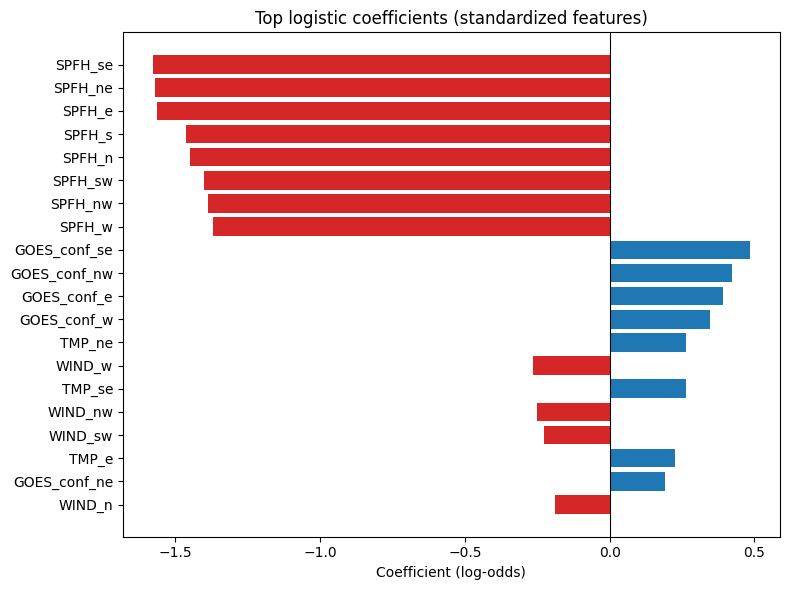

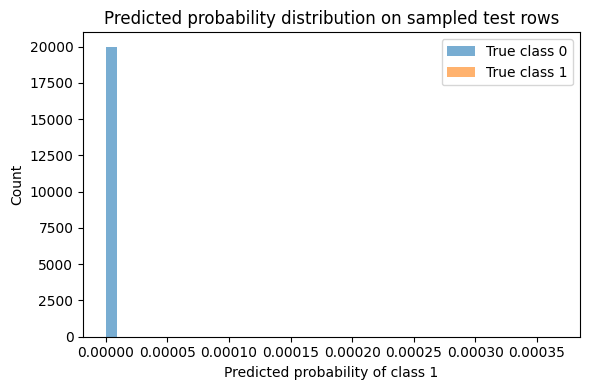

In [23]:
plot_df = coef_df.head(20).iloc[::-1]
colors = ["#1f77b4" if c >= 0 else "#d62728" for c in plot_df["coef"]]

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["coef"], color=colors)
plt.axvline(0.0, color="black", linewidth=0.8)
plt.title("Top logistic coefficients (standardized features)")
plt.xlabel("Coefficient (log-odds)")
plt.tight_layout()
plt.show()

if len(diag_y) > 0:
    y_arr = np.array(diag_y)
    prob_arr = np.array(diag_prob)

    plt.figure(figsize=(6.0, 4.0))
    plt.hist(prob_arr[y_arr == 0], bins=40, alpha=0.6, label="True class 0")
    plt.hist(prob_arr[y_arr == 1], bins=40, alpha=0.6, label="True class 1")
    plt.title("Predicted probability distribution on sampled test rows")
    plt.xlabel("Predicted probability of class 1")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [24]:
report = {
    "model": "logistic_regression",
    "target": "center_confidence_t_plus_1_binary",
    "thresholds": {
        "positive_confidence": POSITIVE_THRESHOLD,
        "classification_probability": CLASSIFICATION_PROB_THRESHOLD,
    },
    "split": {
        "train_fraction": TRAIN_FRACTION,
        "test_fraction": 1.0 - TRAIN_FRACTION,
        "split_seed": SPLIT_SEED,
    },
    "feature_order": FEATURE_NAMES,
    "metrics_test": {
        "accuracy": test_accuracy,
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
        "tn": int(tn),
    },
    "class_balance": {
        "train_positive_rate": train_pos_rate,
        "test_positive_rate": test_pos_rate,
        "train_positives": int(train_pos),
        "train_negatives": int(train_neg),
        "test_positives": int(test_pos),
        "test_negatives": int(test_neg),
    },
    "coefficients": {
        "intercept": intercept,
        "values": coef_map,
    },
    "feature_mean_train": {k: float(v) for k, v in zip(FEATURE_NAMES, x_mean)},
    "feature_std_train": {k: float(v) for k, v in zip(FEATURE_NAMES, x_std)},
    "data": {
        "total_samples": int(n_total_samples),
        "train_samples": int(n_train_samples),
        "test_samples": int(n_test_samples),
        "hours_used": int(n_hours_used),
        "goes_path": str(GOES_PATH),
        "rtma_manifest_path": str(RTMA_MANIFEST),
    },
}

if REPORT_OUTPUT_PATH:
    out = Path(REPORT_OUTPUT_PATH).expanduser()
    if not out.is_absolute():
        out = (REPO_ROOT / out).resolve()
    out.parent.mkdir(parents=True, exist_ok=True)
    out.write_text(json.dumps(report, indent=2), encoding="utf-8")
    print("Saved report:", out)

print("Report keys:", list(report.keys()))


Report keys: ['model', 'target', 'thresholds', 'split', 'feature_order', 'metrics_test', 'class_balance', 'coefficients', 'feature_mean_train', 'feature_std_train', 'data']


## Notes and constraints

- GOES confidence is a proxy signal, not direct flame-front geometry.
- This is a linear decision-boundary model (logistic regression), so non-linear effects are not modeled.
- Wind direction is used as raw degrees because the request is to include all available cell data.
- Split is deterministic by hour index + seed, so repeated runs with the same config produce the same train/test partition.
- Accuracy is classification accuracy on the held-out test split using probability cutoff `0.50`.
- Runtime can be substantial because this uses all samples and three full passes over aligned data.
